In [2]:
import pandas as pd 
import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# inheirited class of a reinforcement learning
class RL(object): 
    def __init__(self, true_distributions, treatment_costs, classification_acc=0.9, epsilon = 0.1):  
        self.true_dist = true_distributions
        self.treatment_costs = treatment_costs
        self.epsilon = epsilon
        self.classification_acc = classification_acc
        
        self.customers = [c for c in true_distributions]
        self.treatments = [t for t in treatment_costs]
        self.customer_freq = [self.true_dist[customer]["frequency"] for customer in self.true_dist]
        
        self.count = None
        plt.style.use("ggplot")
        
    
    def customer_arrival(self):
        """Selects a customer to arrive based on their weighted proabilities
        
        Returns:
            str: name of the selected customer
        """
        return random.choices(self.customers, weights=self.customer_freq)[0]

    
    def classify_customer(self, customer):
        """Classifies the known customer given an classification accuracy
        
        Args:
            customer(str): the name of the known customer
        
        Returns:
            str: The name of the customer the algorithm thinks it is
        """
        if self.classification_acc > stats.uniform.rvs():
            return customer
        else:
            remaining_customers = self.customers.copy()
            remaining_customers.remove(customer)
            return random.choice(remaining_customers)
        
    
    def reward(self, customer, treatment):
        """Returns the binary reward drawn from a known distribution 
            based on customer and action
               
        Args:
            customer (str): the customer type
            treatment (str): the treatment name
            
        Returns:
            str: the result of applying the treatment to this customer
        """
        bernoulli_prob = self.true_dist[customer]["treatments"][treatment]
        return stats.bernoulli.rvs(p=bernoulli_prob)
    
    def customer_sim(self):
        """Simulates the arrival, classification, treatment application, 
           and reward of a single customer.
           
           Uses the sample average method to calculate the reward.
              
        Returns:
            listof(str, str, str, int): real customer type, classified customer type,
                                        the treatement applied, and conversion result
        """
        customer = self.customer_arrival()
        classification = self.classify_customer(customer)
        treatment = self.action()
        reward = self.reward(classification, treatment)
        return [customer, classification, treatment, reward]
    
    
    
    def visualize_reward(self):
        """Plots a linear relationship between trail count and expected reward
        
        Returns:
            plot (plt): A graph of time vs. expected reward
        """
        if self.count == None:
            raise ValueError("The simulation must be run before visualizing!")
        
        expected_reward = 0
        reward_history = []
        
        for i, r in enumerate(self.history["conversion"]):
            expected_reward = expected_reward + ((1/(i+1)) * (r - expected_reward))
            reward_history.append(expected_reward)
        
        self.reward_history = reward_history
        plt.title("Expected Reward of K-Arm Bandit")
        plt.plot(range(0, len(reward_history)), reward_history)
        plt.ylabel("Conversion Rate")
        plt.xlabel("Number of customers")
        return plt.show()
    
    
    def visualize_known(self):
        """Plots the known conversion probability of each treatment for each customer
            
        Returns:
            plt: A bar chart of conversion probability by treatement and customer
        """
        data = []
        for customer in self.true_dist:
            for t in self.true_dist[customer]["treatments"]:
                data.append([customer, t, self.true_dist[customer]["treatments"][t]])
        data = pd.DataFrame(data, columns=["customer", "treatment", "true_dist"])
        plt.figure(figsize=(6,4))
        ax = sns.barplot(x="treatment", y="true_dist", hue="customer", data=data)
        ax.set_title('Probability of converting for each treatment by customer')
        ax.set_ylabel('Bernoulli Probability of Success')
        return ax
    
    
    def visualize_treatment_count(self, first_n):
        """Plots the number of time each treatment has been offered to each customer type
        
        Returns:
            plt: A bar chart of treatment count by treatment and customer
        """
        if self.count == None:
            raise ValueError("The simulation must be run before visualizing!")
        
        return sns.countplot(data=self.history[:first_n], y="treatment", hue="customer")
    
    
    def max_treatment(self, expectations):
        """Returns a list of the treatments with the highest expectation 
        
        Args:
            expectations (dict: [treatment]: expectation): treatments and the expected values

        Returns:
            (listof str): returns the names of all treatments that have max values
        """
        current_max = -1 # in this example, all rewards > 1
        max_treatments = []
        for t in expectations:
            if expectations[t] > current_max:
                current_max = expectations[t]
                max_treatments = [t]
            elif expectations[t] == current_max:
                max_treatments.append(t)
        return max_treatments
    
    
    def expectations(self):
        """
        Calculates the expected reward for each treatment
        """
        expectations = {}
        for t in self.treatments:
            if self.observations[t] <= 0:
                expectations[t] = 0
            else:
                expectations[t] = round(self.rewards[t] / self.observations[t], 4)
        return expectations

In [4]:
class KArm(RL):
    def action(self):
        """Selects an action to take based on epsilon greedy method
        
        Returns: 
            str: the name of the selected treatment 
        """
        if self.epsilon > stats.uniform.rvs():
            return random.choice(self.treatments)
        else:
            expectations = self.expectations()
            return random.choice(self.max_treatment(expectations))
        
        
    
    def sim_run(self, count):
        """Runs customer_sim N times and saves the results and changing expecations
        
        Modifies:
            count (int): changes to the number iterations ran
            rewards (dict): sums the total reward seen for each treatment
            observations (dict): counts the total number of each treatment seen
            history (DataFrame): creates a dataframe of all simulations and results
        """
        self.count = 0
        self.rewards = {t: 0 for t in self.treatments}
        self.observations = {t: 0 for t in self.treatments}
        self.history = []
        
        for i in range(count):
            sim_result = self.customer_sim()
            self.history.append(sim_result)
            self.count += 1 
            self.rewards[sim_result[2]] += sim_result[3]
            self.observations[sim_result[2]] += 1
        
        columns = ["customer", "classification", "treatment", "conversion"]
        self.history = pd.DataFrame(self.history, columns=columns)

In [5]:
class Contextual(RL):
    def expectations(self):
        """
        Calculates the expected reward for each treatment with each customer type
        """
        expectations = {c : {} for c in self.customers}
        for c in self.customers:
            for t in self.treatments:
                if self.observations[c][t] <= 0:
                    expectations[c][t] = 0
                else:
                    expectations[c][t] = round(self.rewards[c][t] / self.observations[c][t], 4)
        return expectations
    
    def action(self, customer):
        """Selects an action to take based on epsilon greedy method
        
        Returns: 
            str: the name of the selected treatment 
        """
        if self.epsilon > stats.uniform.rvs():
            return random.choice(self.treatments)
        else:
            expectations = self.expectations()
            return random.choice(self.max_treatment(expectations[customer]))
        
    def customer_sim(self):
        """Simulates the arrival, classification, treatment application, 
           and reward of a single customer.
           
           Uses the sample average method to calculate the reward.
              
        Returns:
            listof(str, str, str, int): real customer type, classified customer type,
                                        the treatement applied, and conversion result
        """
        customer = self.customer_arrival()
        classification = self.classify_customer(customer)
        treatment = self.action(customer)
        reward = self.reward(classification, treatment)
        return [customer, classification, treatment, reward]
    
    def sim_run(self, count):
        """Runs customer_sim N times and saves the results and changing expecations
        
        Modifies:
            count (int): changes to the number iterations ran
            rewards (dict): sums the total reward seen for each treatment
            observations (dict): counts the total number of each treatment seen
            history (DataFrame): creates a dataframe of all simulations and results
        """
        customer_index = 0
        classification_index = 1
        treatment_index = 2
        reward_index = 3
        self.count = 0
        self.rewards = {c: {t: 0 for t in self.treatments} for c in self.customers}
        self.observations = {c: {t: 0 for t in self.treatments} for c in self.customers}
        self.history = []
        
        for i in range(count):
            sim_result = self.customer_sim()
            self.history.append(sim_result)
            self.count += 1 
            self.rewards[sim_result[customer_index]][sim_result[treatment_index]] += sim_result[reward_index]
            self.observations[sim_result[customer_index]][sim_result[treatment_index]] += 1
        
        columns = ["customer", "classification", "treatment", "conversion"]
        self.history = pd.DataFrame(self.history, columns=columns)

### Example
A sample dictionary of true values and treatment costs

In [22]:
cd = {
    "frequent": {
        "treatments": {
            "No discount": 0.01,
            "5% off": 0.2,
            "Coupon": 0.06,
        },
        "frequency": 0.3,
        "classification_acc": 0.8,
    },
    
    "infrequent": {
        "treatments": {
            "No discount": 0.04,
            "5% off": 0.05,
            "Coupon": 0.21,
        },
        "frequency": 0.7,
        "classification_acc": 0.95,
    },
}

treatment_costs = {
    "No discount": 0,
    "5% off": 5,
    "Coupon": 10, 
}

r = KArm(cd, treatment_costs)

In [23]:
r.sim_run(50000)

In [24]:
k = Contextual(cd, treatment_costs)

In [25]:
k.sim_run(50000)

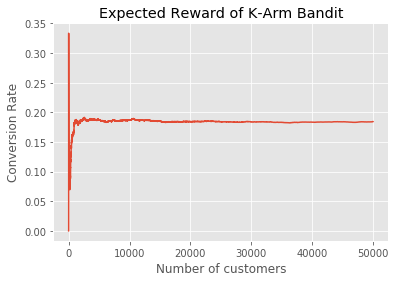

In [26]:
k.visualize_reward()

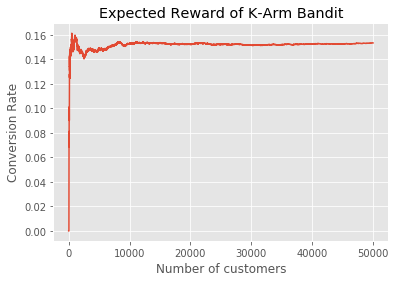

In [27]:
r.visualize_reward()